# Imports

In [1]:
import pickle
import os
import re
import glob
import random
import numpy as np
import scipy
import scipy.io as sio
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.patches import Patch, Circle
from matplotlib.lines import Line2D
from PIL import Image
import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual  # package for interactive widgets 
import braingeneers                                                   # Braingeneers code
from braingeneers.analysis.analysis import SpikeData, read_phy_files
import braingeneers.data.datasets_electrophysiology as ephys
from IPython.display import HTML, display, Javascript, clear_output
from matplotlib.patches import FancyArrow

# <font color="gray"> Sttc and num spikes threshold

In [3]:
import pickle
file = open('/home/jovyan/work/Human_Hippocampus/5-10-23s1-CutData.pkl', 'rb')
stitched_data = pickle.load(file)
file.close()

In [4]:
sd = stitched_data

In [5]:
def find_pairs(sd, sttc_threshold=0.7, num_threshold=200):
    sttc = np.zeros((sd.N, sd.N))
    for i in range(sd.N):
        for j in range(sd.N):
            if i == j: 
                sttc[i][j]=0
            else:
                sttc[i][j] = sd.spike_time_tiling(i, j)

    # Create a mask to filter STTC values above the given threshold
    mask = sttc > sttc_threshold

    # Find the indices of neuron pairs with STTC above the threshold
    neuron_pairs = np.transpose(np.where(mask))
    
    select_pairs = []
    
    for i, neuron_pair in enumerate(neuron_pairs):
        print(i)
        neuron1, neuron2 = neuron_pair
        lates_n1 = sd.latencies_to_index(neuron1)
        lates_num = len(lates_n1[neuron2])
        if lates_num > num_threshold:
            select_pairs.append((neuron1, neuron2))

    return select_pairs

In [6]:
pairs = find_pairs(sd)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


In [7]:
pairs

[(5, 67),
 (5, 94),
 (5, 98),
 (6, 13),
 (6, 35),
 (13, 6),
 (13, 32),
 (13, 35),
 (20, 28),
 (27, 80),
 (28, 20),
 (32, 13),
 (35, 6),
 (35, 13),
 (48, 95),
 (60, 93),
 (62, 66),
 (62, 68),
 (62, 76),
 (62, 82),
 (66, 62),
 (66, 68),
 (66, 76),
 (66, 82),
 (67, 5),
 (67, 94),
 (67, 98),
 (68, 62),
 (68, 66),
 (68, 76),
 (68, 82),
 (72, 84),
 (72, 99),
 (76, 62),
 (76, 66),
 (76, 68),
 (76, 82),
 (80, 27),
 (82, 62),
 (82, 66),
 (82, 68),
 (82, 76),
 (84, 72),
 (84, 99),
 (93, 60),
 (94, 5),
 (94, 67),
 (94, 98),
 (95, 48),
 (98, 5),
 (98, 67),
 (98, 94),
 (99, 72),
 (99, 84)]

# Get and Save latencies

In [8]:
lates_raw = []
for i, neuron_pair in enumerate(pairs):
    print(i)
    neuron1, neuron2 = neuron_pair
    lates_n1 = sd.latencies_to_index(neuron1)
    lates_raw.append( lates_n1[neuron2] )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


In [9]:
import pickle
file_path = '5_10_23_s1_Stitched_Latencies.pkl'
data = { "pairs":pairs, "latencies":lates_raw }
# open a file, where you ant to store the data
file = open('5_10_23_s1_Stitched_Latencies.pkl', 'wb')
pickle.dump(data, file)
file.close()

# Curate Latencies

load data

In [13]:
import pickle
file = open('5_10_23_s1_Stitched_Latencies.pkl', 'rb')
data = pickle.load(file)
lates_pairs = data["pairs"]
lates = data["latencies"]
file.close()

remove latencies below 10 ms

In [14]:
max_ms = 10
lates_short = []
for latency_dist in lates:
    lates_short.append( list(filter(lambda x: x < max_ms and x > -max_ms, latency_dist))  )

In [28]:
direction_threshold = .55

lates_directed = []
pairs_directed = []

for i in range(len(lates_short)):
    lates_i = np.array(lates_short[i])
    print(len(lates_i))
    if len(lates_i) == 0:
        continue
    percent_neg = sum( lates_i<0 )/len(lates_i)
    percent_pos = sum( lates_i>0 )/len(lates_i)
    
    if percent_neg > direction_threshold or percent_pos > direction_threshold:
        lates_directed.append( lates_i )
        pairs_directed.append( lates_pairs[i] )

309
296
306
262
267
258
208
232
214
299
227
204
263
232
393
447
441
445
444
450
437
436
428
438
306
365
369
444
440
434
444
474
416
454
442
444
449
311
448
439
441
437
519
486
438
293
365
355
400
304
371
356
444
472


<font color="brown">other code

In [25]:
len(pairs_lates_directed)

44

# Make Plot

get neuron maping

In [29]:
neuron_x = []
neuron_y = []
for neuron in stitched_data.neuron_data[0].values():
    neuron_x.append(neuron['position'][0])
    neuron_y.append(neuron['position'][1])

/tmp/ipykernel_2324127/2928667712.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in stitched_data.neuron_data[0].values():


make plot


/tmp/ipykernel_2324127/3049447448.py:36: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow(


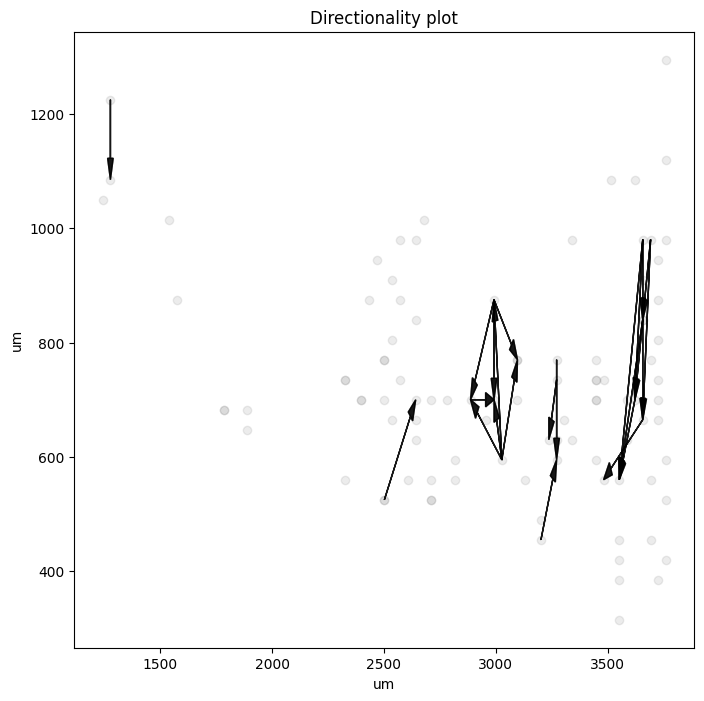

In [30]:
# Set up figure
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

plt.scatter(neuron_x, neuron_y, alpha=0.15, c='grey')

# Plot each individual arrow
for i in range(len(lates_directed)):
    
    # Get starting and ending arrow based on direction
    is_pos = np.median(lates_directed[i]) > 0
    if is_pos:
        start_i = pairs_directed[i][0]
        end_i = pairs_directed[i][1]
    else:
        start_i = pairs_directed[i][1]
        end_i = pairs_directed[i][0]

        
    #arrow_color="black"
    #if (neuron_y[start_i] < 500 or neuron_y[end_i] < 500):
    #    arrow_color="green"
    #    
    #if neuron_x[start_i] < neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
    #    arrow_color="red"
    # 
    #if neuron_x[start_i] > neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
    #    arrow_color = "blue"
        
        #         continue
        
    #if neuron_y[start_i] < neuron_y[end_i]:
    #    continue
   
    arrow_color="black"
    # Add arrow
    arrow = FancyArrow(
        neuron_x[end_i], neuron_y[end_i],
        neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i],
        length_includes_head=True, head_width=25,
        linewidth=1, color=arrow_color, alpha=0.7, edgecolor=arrow_color, facecolor=arrow_color)
    plt.gca().add_patch(arrow)
    

plt.xlabel('um')
plt.ylabel('um')
plt.title("Directionality plot")  # Adding the title
plt.show()

# Old Stuff

In [ ]:
max_ms = 10
lates_short = []
for latency_dist in lates:
    lates_short.append( list(filter(lambda x: x < max_ms and x > -max_ms, latency_dist))  )

In [ ]:
direction_threshold = .65

lates_directed = []
pairs_directed = []

for i in range(len(lates_short)):
    lates_i = np.array(lates_short[i])
    print(len(lates_i))
    if len(lates_i) == 0:
        continue
    percent_neg = sum( lates_i<0 )/len(lates_i)
    percent_pos = sum( lates_i>0 )/len(lates_i)
    
    if percent_neg > direction_threshold or percent_pos > direction_threshold:
        lates_directed.append( lates_i )
        pairs_directed.append( lates_pairs[i] )

# Old Stuff


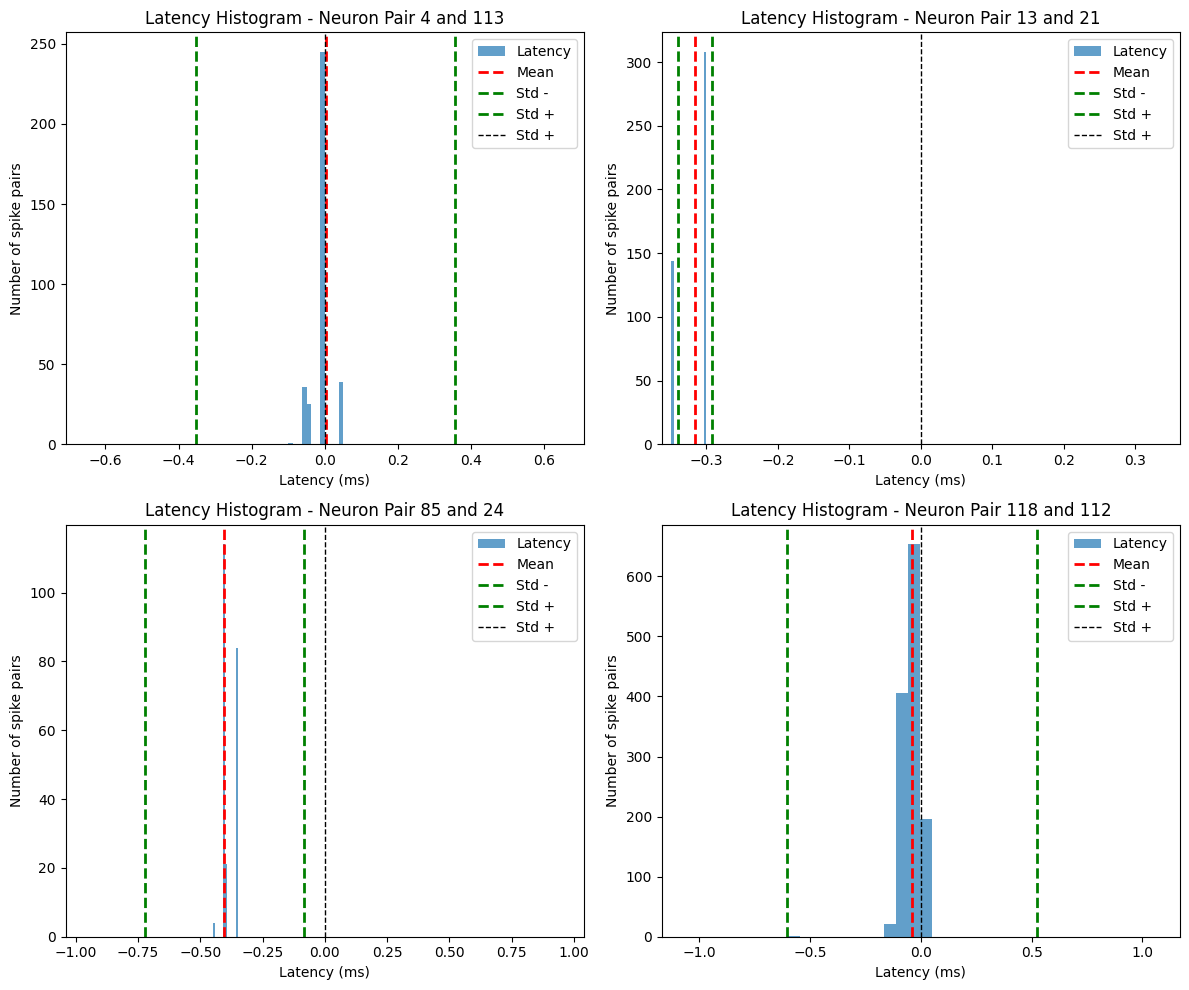

In [33]:
def plot_latency_histograms_for_random_pairs(sd, threshold=0.3, num_random_pairs=4):
    neuron_pairs = np.array(pairs)

    # Get 'num_random_pairs' random indices to choose random neuron pairs
    random_indices = np.random.choice(neuron_pairs.shape[0], num_random_pairs, replace=False)
    random_neuron_pairs = neuron_pairs[random_indices]

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.ravel()

    for i, neuron_pair in enumerate(random_neuron_pairs):
        neuron1, neuron2 = neuron_pair
        lates_n1 = sd.latencies_to_index(neuron1)
        lates_raw = lates_n1[neuron2]
        lates = list(filter(lambda x: x < 10 and x > -10, lates_raw))

        mean_latency = np.mean(lates)
        std_latency = np.std(lates)
        cutoff = 2 * std_latency

        # Remove values more than 2 standard deviations away from mean
        lates_filtered = [latency for latency in lates if abs(latency - mean_latency) <= cutoff]

        axs[i].hist(lates_filtered, bins=12, alpha=0.7, label='Latency')
        axs[i].axvline(mean_latency, color='red', linestyle='dashed', linewidth=2, label='Mean')
        axs[i].axvline(mean_latency - std_latency, color='green', linestyle='dashed', linewidth=2, label='Std -')
        axs[i].axvline(mean_latency + std_latency, color='green', linestyle='dashed', linewidth=2, label='Std +')
        axs[i].axvline(0, color='black', linestyle='dashed', linewidth=0.5, label='Std +')
        #axs[i].set_xlim(-0.5, 0.5)
        axs[i].set_xlim(-1*(abs(mean_latency)+cutoff), abs(mean_latency) + cutoff) 
        #axs[i].set_ylim( , abs(mean_latency)+cutoff )
        axs[i].set_xlabel("Latency (ms)")
        axs[i].set_ylabel("Number of spike pairs")
        axs[i].set_title(f"Latency Histogram - Neuron Pair {neuron1} and {neuron2}")
        axs[i].legend()

    plt.tight_layout()
    plt.show()

# Call the function with your SpikeData object, the desired STTC threshold, and the number of random pairs to plot
plot_latency_histograms_for_random_pairs(sd, threshold=0.3, num_random_pairs=4)

In [43]:
def plot_latency_histograms_for_random_pairs(sd, threshold=0.7, num_thresh = 1000, num_random_pairs=9):
    neuron_pairs = np.array(find_pairs(sd, sttc_threshold=threshold, num_threshold=num_thresh))
    
    print(len(neuron_pairs))

    # Get 'num_random_pairs' random indices to choose random neuron pairs
    random_indices = np.random.choice(neuron_pairs.shape[0], num_random_pairs, replace=False)
    random_neuron_pairs = neuron_pairs[random_indices]
    
    fig, axs = plt.subplots(3, 3, figsize=(30, 30))
    axs = axs.ravel()

    for i, neuron_pair in enumerate(random_neuron_pairs):
        neuron1, neuron2 = neuron_pair
        lates_n1 = sd.latencies_to_index(neuron1)
        lates_raw = lates_n1[neuron2]
        lates = list(filter(lambda x: x < 10 and x > -10, lates_raw))

        mean_latency = np.mean(lates)
        std_latency = np.std(lates)
        cutoff = 2 * std_latency

        # Remove values more than 2 standard deviations away from mean
        lates_filtered = [latency for latency in lates if abs(latency - mean_latency) <= cutoff]

        axs[i].hist(lates_filtered, alpha=0.7, label='Latency') #bins=30, 
        axs[i].axvline(mean_latency, color='red', linestyle='dashed', linewidth=2, label='Mean')
        axs[i].axvline(mean_latency - std_latency, color='green', linestyle='dashed', linewidth=2, label='Std -')
        axs[i].axvline(mean_latency + std_latency, color='green', linestyle='dashed', linewidth=2, label='Std +')
        axs[i].axvline(0, color='black', linestyle='dashed', linewidth=0.5, label='Std +')
        axs[i].set_xlim(-1*(abs(mean_latency)+cutoff), abs(mean_latency) + cutoff) 
        axs[i].set_xlabel("Latency (ms)")
        axs[i].set_ylabel("Number of spike pairs")
        axs[i].set_title(f"Pair ({neuron1}, {neuron2}): {round(100*(len(lates_filtered)/len(lates_raw)))}% kept")
#         axs[i].legend(loc='upper right')

    # Hide unused subplots
    for i in range(num_random_pairs, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
#     plt.savefig('LatencyDistributions.png')
    plt.show()

# # Call the function with your SpikeData object, the desired STTC threshold, and the number of random pairs to plot
# plot_latency_histograms_for_random_pairs(sd, threshold=0.7, num_thresh = 1000, num_random_pairs=9):

In [44]:
# Call the function with your SpikeData object, the desired STTC threshold, and the number of random pairs to plot
plot_latency_histograms_for_random_pairs(sd, threshold=0, num_thresh = 1000, num_random_pairs=9)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163


KeyboardInterrupt: 

In [ ]:
blue_lates=[]
red_lates =[]
green_lates=[]


# Plot each individual arrow
for i in range(len(lates_directed)):
    
    # Get starting and ending arrow based on direction
    is_pos = np.median(lates_directed[i]) > 0
    if is_pos:
        start_i = pairs_directed[i][0]
        end_i = pairs_directed[i][1]
    else:
        start_i = pairs_directed[i][1]
        end_i = pairs_directed[i][0]

        
    #arrow_color="black"
    if (neuron_y[start_i] < 500 or neuron_y[end_i] < 500):
        green_lates.append( sd.latencies_to_index(end_i)[start_i]  )
        #arrow_color="green"
        #print(start_i)
        
    if neuron_x[start_i] < neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
        #arrow_color="red"
        red_lates.append( sd.latencies_to_index(end_i)[start_i]  )
    
    if neuron_x[start_i] > neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
        #arrow_color = "blue"
        blue_lates.append( sd.latencies_to_index(end_i)[start_i]  )
        

In [ ]:
blue_lates=[]
blue_nums=[]
red_lates =[]
red_nums=[]
green_lates=[]
green_nums=[]


# Plot each individual arrow
for i in range(len(lates_directed)):
    
    # Get starting and ending arrow based on direction
    is_pos = np.median(lates_directed[i]) > 0
    if is_pos:
        start_i = pairs_directed[i][0]
        end_i = pairs_directed[i][1]
    else:
        start_i = pairs_directed[i][1]
        end_i = pairs_directed[i][0]

        
    #arrow_color="black"
    if (neuron_y[start_i] < 500 or neuron_y[end_i] < 500):
        green_lates.append( sd.latencies_to_index(end_i)[start_i]  )
        green_nums.append()
        #arrow_color="green"
        #print(start_i)
        
    if neuron_x[start_i] < neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
        #arrow_color="red"
        red_lates.append( sd.latencies_to_index(end_i)[start_i]  )
    
    if neuron_x[start_i] > neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
        #arrow_color = "blue"
        blue_lates.append( sd.latencies_to_index(end_i)[start_i]  )
        

In [29]:
len((sd.latencies_to_index(31)[12]))

1661

In [30]:
len(sd.train[31])

1664

# <font color="brown">Matt Stuff

## Latencies noncolored


In [48]:
neuron_pairs= np.random.choice(140,2,  replace=False)
neuron1 = neuron_pairs[0]
neuron2 = neuron_pairs[1]

In [53]:
def plot_latency_histograms_for_random_pairs(sd, threshold=0.7, num_thresh = 1000, num_random_pairs=9):
    #neuron_pairs = np.array(find_pairs(sd, sttc_threshold=threshold, num_threshold=num_thresh))
    

    # Get 'num_random_pairs' random indices to choose random neuron pairs
    #random_indices = np.random.choice(neuron_pairs.shape[0], num_random_pairs, replace=False)
    #random_neuron_pairs = neuron_pairs[random_indices]
    
    fig, axs = plt.subplots(3, 3, figsize=(30, 30))
    axs = axs.ravel()
    
    i=0
    while i < 9:
        neuron_pairs= np.random.choice(140,2,  replace=False)
        neuron1 = neuron_pairs[0]
        neuron2 = neuron_pairs[1]

        #neuron1, neuron2 = neuron_pair
        lates_n1 = sd.latencies_to_index(neuron1)
        lates_raw = lates_n1[neuron2]
        lates = list(filter(lambda x: x < 10 and x > -10, lates_raw))
        
        if len(lates_raw) < 1000:
            continue
        
        print("Hi")

        mean_latency = np.mean(lates)
        std_latency = np.std(lates)
        cutoff = 2 * std_latency

        # Remove values more than 2 standard deviations away from mean
        lates_filtered = [latency for latency in lates if abs(latency - mean_latency) <= cutoff]

        axs[i].hist(lates_filtered, alpha=0.7, label='Latency') #bins=30, 
        axs[i].axvline(mean_latency, color='red', linestyle='dashed', linewidth=2, label='Mean')
        axs[i].axvline(mean_latency - std_latency, color='green', linestyle='dashed', linewidth=2, label='Std -')
        axs[i].axvline(mean_latency + std_latency, color='green', linestyle='dashed', linewidth=2, label='Std +')
        axs[i].axvline(0, color='black', linestyle='dashed', linewidth=0.5, label='Std +')
        axs[i].set_xlim(-1*(abs(mean_latency)+cutoff), abs(mean_latency) + cutoff) 
        axs[i].set_xlabel("Latency (ms)")
        axs[i].set_ylabel("Number of spike pairs")
        axs[i].set_title(f"Pair ({neuron1}, {neuron2}): {round(100*(len(lates_filtered)/len(lates_raw)))}% kept")
        i+=1
#         axs[i].legend(loc='upper right')

    # Hide unused subplots
    for i in range(num_random_pairs, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
#     plt.savefig('LatencyDistributions.png')
    plt.show()

# # Call the function with your SpikeData object, the desired STTC threshold, and the number of random pairs to plot
# plot_latency_histograms_for_random_pairs(sd, threshold=0.7, num_thresh = 1000, num_random_pairs=9):

Hi
Hi
Hi
Hi
Hi
Hi
Hi
Hi
Hi


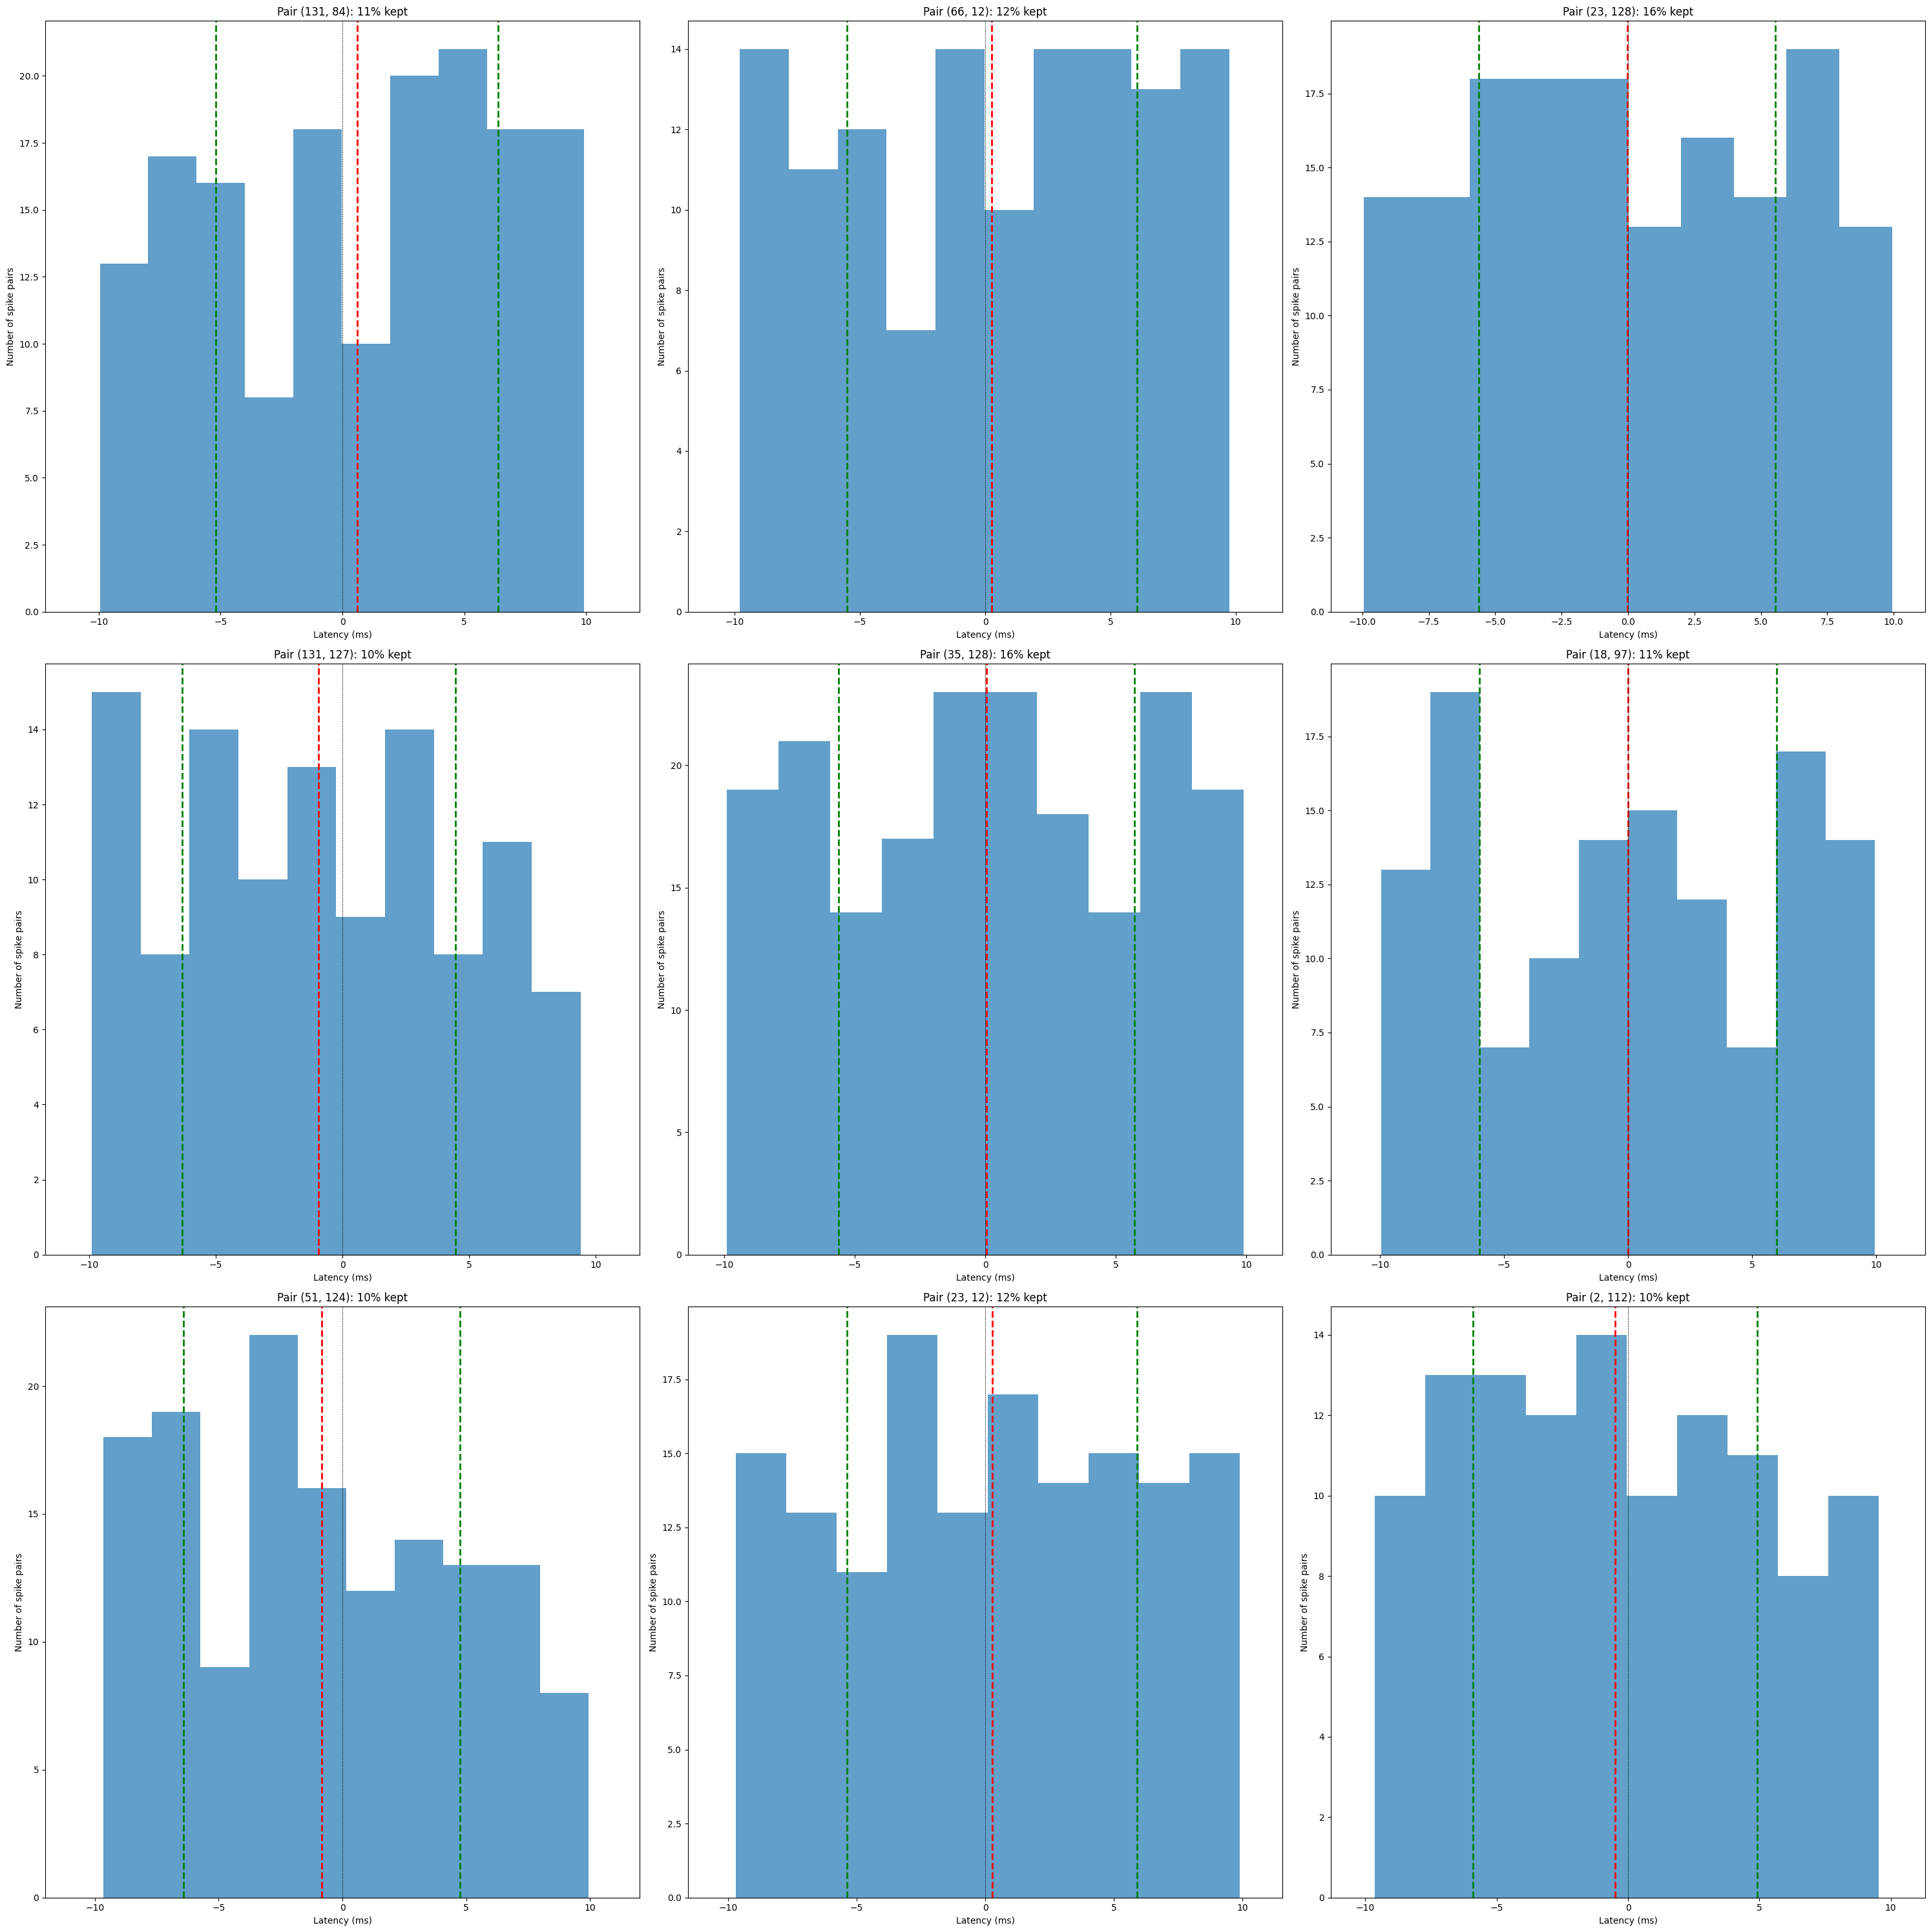

In [55]:
plot_latency_histograms_for_random_pairs(sd)

## Get raw latencies

Get initial neuron pairs

In [6]:
# Usage example:
# Assuming you have a spike data object called 'sd'
neuron_pairs_above_threshold = find_sttc_above_threshold(sd, threshold=0.2)

In [7]:
print(neuron_pairs_above_threshold)
print(len(neuron_pairs_above_threshold))

[[  0 137]
 [  4 113]
 [  9  29]
 [  9 130]
 [ 10 114]
 [ 11 109]
 [ 12  31]
 [ 12  92]
 [ 12 100]
 [ 13  21]
 [ 13  45]
 [ 14  38]
 [ 16  69]
 [ 17  43]
 [ 21  13]
 [ 21  45]
 [ 24  85]
 [ 25 105]
 [ 29   9]
 [ 30  95]
 [ 31  12]
 [ 31  92]
 [ 31 100]
 [ 33  44]
 [ 35  50]
 [ 37  81]
 [ 37 138]
 [ 38  14]
 [ 39  53]
 [ 43  17]
 [ 44  33]
 [ 45  13]
 [ 45  21]
 [ 50  35]
 [ 53  39]
 [ 55 104]
 [ 56 101]
 [ 56 133]
 [ 58  77]
 [ 60  98]
 [ 61  98]
 [ 66  76]
 [ 67  84]
 [ 67 129]
 [ 69  16]
 [ 76  66]
 [ 77  58]
 [ 79 103]
 [ 80 111]
 [ 81  37]
 [ 81 138]
 [ 82  86]
 [ 84  67]
 [ 84 129]
 [ 85  24]
 [ 86  82]
 [ 87 139]
 [ 88 125]
 [ 92  12]
 [ 92  31]
 [ 95  30]
 [ 98  60]
 [ 98  61]
 [100  12]
 [100  31]
 [101  56]
 [101 110]
 [101 133]
 [103  79]
 [103 121]
 [104  55]
 [105  25]
 [109  11]
 [110 101]
 [110 126]
 [110 132]
 [110 133]
 [111  80]
 [112 118]
 [113   4]
 [114  10]
 [118 112]
 [121 103]
 [125  88]
 [126 110]
 [129  67]
 [129  84]
 [130   9]
 [132 110]
 [133  56]
 [133 101]

This function is very inefficient, consider changing it.

In [8]:
lates_raw = []
for i, neuron_pair in enumerate(neuron_pairs_above_threshold):
    print(i)
    neuron1, neuron2 = neuron_pair
    lates_n1 = sd.latencies_to_index(neuron1)
    lates_raw.append( lates_n1[neuron2] )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


Save data, in case kernel breaks

## Save Data

In [9]:
import pickle

In [10]:
file_path = 'Stitched_Latencies.pkl'

In [11]:
data = { "pairs":neuron_pairs_above_threshold, "latencies":lates_raw }

In [12]:
# open a file, where you ant to store the data
file = open('Stitched_Latencies.pkl', 'wb')
pickle.dump(data, file)
file.close()

## Load Data

There are two datasets you can read in:

"Raw_Latencies_0.2.pkl" : gives 44 directed pairs

"Raw_Latencies_0.6.pkl" : gives 28 directed pairs

In [4]:
import pickle
file = open('Stitched_Latencies.pkl', 'rb')
data = pickle.load(file)
lates_pairs = data["pairs"]
lates = data["latencies"]
file.close()

In [6]:
max_ms = 10
lates_short = []
for latency_dist in lates:
    lates_short.append( list(filter(lambda x: x < max_ms and x > -max_ms, latency_dist))  )

In [7]:
pairs_lates = {}

for i, pair in enumerate(lates_pairs):
    key = tuple(pair)
    if key not in pairs_lates:
        pairs_lates[key] = []
    pairs_lates[key].append(lates_short[i])

# Print the resulting dictionary
for key, values in pairs_lates.items():
    print(f"{key}: {values}")

(0, 137): [[-2.1999999999970896, -4.44999999999709, 0.9500000000007276, -1.8999999999978172, 0.09999999999126885, -0.8500000000058208, 9.049999999995634, -0.8000000000029104, -1.5, -9.900000000001455, -9.19999999999709, 7.599999999998545, 7.149999999994179, -9.25, 4.500000000007276, -8.649999999986903, 0.9000000000087311, 4.900000000008731, -9.10000000000582, 7.849999999991269, 9.64999999999418, -2.25, -1.1500000000087311, -1.1500000000087311, 7.400000000008731, 4.550000000017462, -6.900000000008731, -1.3999999999941792, 4.19999999999709, 3.8999999999941792, -1.0499999999883585, 8.39999999999418, -1.8999999999941792, 4.30000000000291, -0.9000000000087311, -2.7000000000116415, 1.5499999999883585, -1.9000000000087311, -5.149999999994179, 6.850000000005821, 0.3500000000203727, 6.899999999994179, 6.099999999991269, -4.80000000000291, -5.19999999999709, -2.1499999999941792, -5.900000000008731, 7.150000000008731, 6.400000000008731, -1.0, -9.599999999991269, -0.5, 6.44999999999709, -2.6500000

In [8]:
# Create the pairs_lates_directed dictionary
direction_threshold = 0.65
pairs_lates_directed = {}

for key, values in pairs_lates.items():
    #print((len(values[0])))
    lates_i = np.array(values[0])
    #print(lates_i)
    
    if len(lates_i) == 0:
        continue
    percent_neg = sum(lates_i < 0) / len(lates_i)
    percent_pos = sum(lates_i > 0) / len(lates_i)
    
    if percent_neg > direction_threshold or percent_pos > direction_threshold:
        pairs_lates_directed[key] = lates_i

In [41]:
len(pairs_lates_directed)

54

In [12]:
import pickle
file_path = '/home/jovyan/work/Human_Hippocampus/Pairs_and_Lates_Directed.pkl'
data = { "pairs_lates":pairs_lates_directed }

In [16]:
# open a file, where you ant to store the data
file = open('/home/jovyan/work/Human_Hippocampus/Pairs_and_Lates_Directed.pkl', 'wb')
pickle.dump(data, file)
file.close()

In [1]:
import pickle
file = open('/home/jovyan/work/Human_Hippocampus/Pairs_and_Lates_Directed.pkl', 'rb')
data = pickle.load(file)
pairs_lates_dict = data["pairs_lates"]
file.close()

In [42]:
neuron_x = []
neuron_y = []
for neuron in sd.neuron_data[0].values():
    neuron_x.append(neuron['position'][0])
    neuron_y.append(neuron['position'][1])

/tmp/ipykernel_1853342/3713121702.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


/tmp/ipykernel_1853342/854614328.py:41: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow(


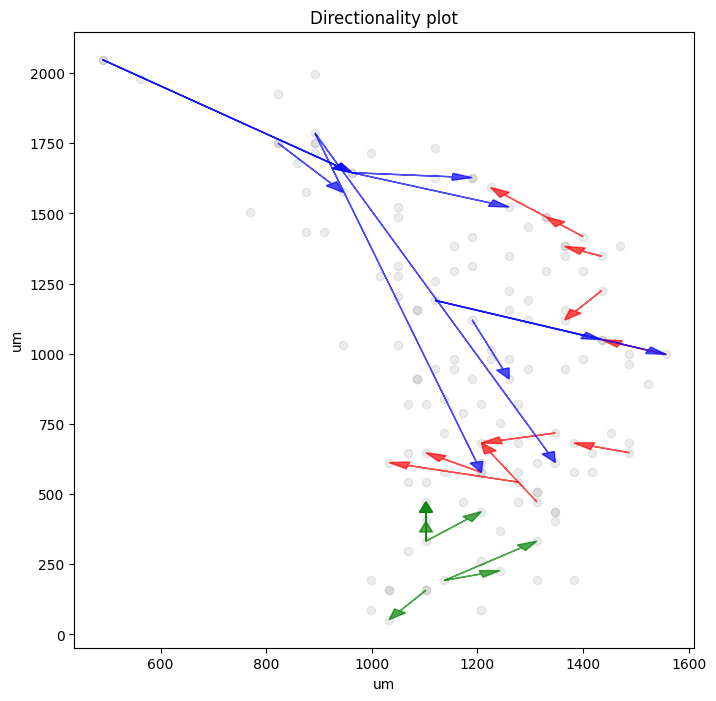

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow

# Assuming you have 'pairs_lates_directed' dictionary and neuron_x, neuron_y arrays
# pairs_lates_directed = { (pair): np.array(entries), ... }
# neuron_x = ...  # Your x-coordinates
# neuron_y = ...  # Your y-coordinates

direction_threshold = 0.65

plt.figure(figsize=(8, 8))

plt.scatter(neuron_x, neuron_y, alpha=0.15, c='grey')

for pair, entries in pairs_lates_directed.items():
    lates_i = np.array(entries)
    
    if len(lates_i) == 0:
        continue
    
    percent_neg = np.sum(lates_i < 0) / len(lates_i)
    percent_pos = np.sum(lates_i > 0) / len(lates_i)
    
    # Check the direction and conditions
    is_pos = np.median(lates_i) > 0
    if is_pos and percent_pos > direction_threshold:
        start_i = pair[0]
        end_i = pair[1]
        
        arrow_color = "black"
        if neuron_y[start_i] < 500 or neuron_y[end_i] < 500:
            arrow_color = "green"
            
        if neuron_x[start_i] < neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
            arrow_color = "red"
        
        if neuron_x[start_i] > neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
            arrow_color = "blue"
            
        arrow = FancyArrow(
            neuron_x[end_i], neuron_y[end_i],
            neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i],
            length_includes_head=True, head_width=25,
            linewidth=1, color=arrow_color, alpha=0.7, edgecolor=arrow_color, facecolor=arrow_color)
        plt.gca().add_patch(arrow)

plt.xlabel('um')
plt.ylabel('um')
plt.title("Directionality plot")
plt.show()


/tmp/ipykernel_1853342/1344877754.py:48: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow(


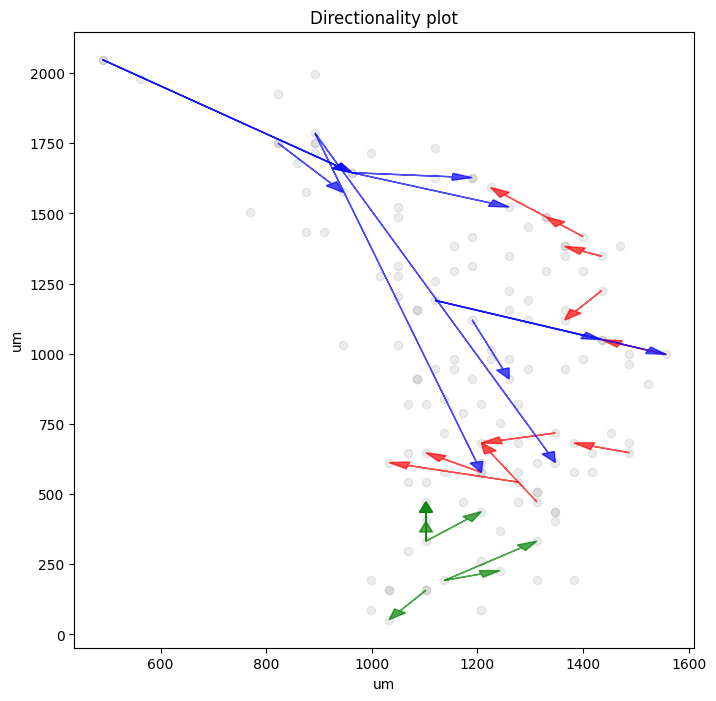

Green neurons: [(56, 101), (56, 133), (76, 66), (84, 67), (101, 133), (110, 133), (129, 67)]
Red neurons: [(12, 92), (12, 100), (14, 38), (21, 45), (25, 105), (53, 39), (77, 58), (80, 111), (112, 118), (139, 87)]
Blue neurons: [(21, 13), (24, 85), (37, 81), (45, 13), (79, 103), (98, 60), (98, 61), (121, 103), (130, 9), (138, 81)]


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow

# Assuming you have 'pairs_lates_directed' dictionary and neuron_x, neuron_y arrays
# pairs_lates_directed = { (pair): np.array(entries), ... }
# neuron_x = ...  # Your x-coordinates
# neuron_y = ...  # Your y-coordinates

direction_threshold = 0.65

plt.figure(figsize=(8, 8))

plt.scatter(neuron_x, neuron_y, alpha=0.15, c='grey')

green_neurons = []
red_neurons = []
blue_neurons = []

for pair, entries in pairs_lates_directed.items():
    lates_i = np.array(entries)
    
    if len(lates_i) == 0:
        continue
    
    percent_neg = np.sum(lates_i < 0) / len(lates_i)
    percent_pos = np.sum(lates_i > 0) / len(lates_i)
    
    # Check the direction and conditions
    is_pos = np.median(lates_i) > 0
    if is_pos and percent_pos > direction_threshold:
        start_i = pair[0]
        end_i = pair[1]
            
        arrow_color = "black"
        if neuron_y[start_i] < 450 or neuron_y[end_i] < 450:
            arrow_color = "green"
            green_neurons.append(pair)
            
        if neuron_x[start_i] < neuron_x[end_i] and (neuron_y[start_i] > 450 or neuron_y[end_i] > 450):
            arrow_color = "red"
            red_neurons.append(pair)
        
        if neuron_x[start_i] > neuron_x[end_i] and (neuron_y[start_i] > 450 or neuron_y[end_i] > 450):
            arrow_color = "blue"
            blue_neurons.append(pair)
            
        arrow = FancyArrow(
            neuron_x[end_i], neuron_y[end_i],
            neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i],
            length_includes_head=True, head_width=25,
            linewidth=1, color=arrow_color, alpha=0.7, edgecolor=arrow_color, facecolor=arrow_color)
        plt.gca().add_patch(arrow)

plt.xlabel('um')
plt.ylabel('um')
plt.title("Directionality plot")
plt.show()

print("Green neurons:", green_neurons)
print("Red neurons:", red_neurons)
print("Blue neurons:", blue_neurons)

In [52]:
green = sorted(list(set([num for pair in green_neurons for num in pair])))
red = sorted(list(set([num for pair in red_neurons for num in pair])))
blue = sorted(list(set([num for pair in blue_neurons for num in pair])))

print("Green neurons:", green)
print("Red neurons:", red)
print("Blue neurons:", blue)

Green neurons: [56, 66, 67, 76, 84, 101, 110, 129, 133]
Red neurons: [12, 14, 21, 25, 38, 39, 45, 53, 58, 77, 80, 87, 92, 100, 105, 111, 112, 118, 139]
Blue neurons: [9, 13, 21, 24, 37, 45, 60, 61, 79, 81, 85, 98, 103, 121, 130, 138]


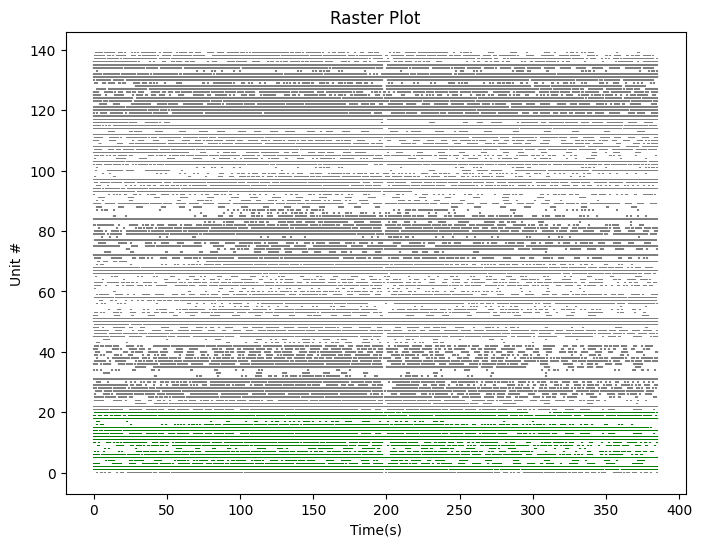

In [60]:
def plot_raster_colored(sd, ax):
    idces, times = sd.idces_times()

    colors = ['green' if 1 idx in li else 'grey' for idx in idces]
    
    ax.scatter(times/1000, idces, marker='|', s=1, color=colors)
    
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax.set_title("Raster Plot")

# Assuming you have 'sd' (some data) and 'ax' (axis) created

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figsize as needed

# Call the modified function
plot_raster_colored(sd, ax)

plt.show()

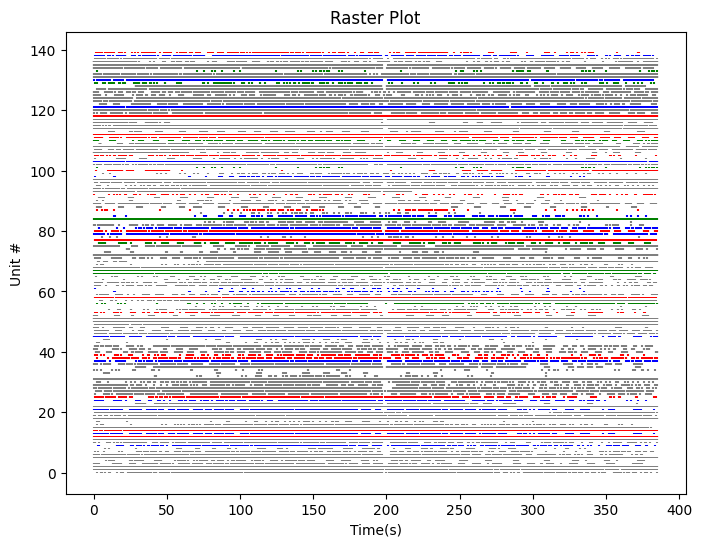

In [62]:
def plot_raster_colored(sd, ax, green_neurons, blue_neurons, red_neurons):
    idces, times = sd.idces_times()

    colors = ['green' if idx in green_neurons else 'blue' if idx in blue_neurons else 'red' if idx in red_neurons else 'grey' for idx in idces]
    
    ax.scatter(times/1000, idces, marker='|', s=1, color=colors)
    
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax.set_title("Raster Plot")

# Assuming you have 'sd' (some data) and 'ax' (axis) created

# Define the neuron lists for each color
green_neurons = [1, 2, 3, ...]  # Replace with your green neuron numbers
blue_neurons = [21, 22, 23, ...]  # Replace with your blue neuron numbers
red_neurons = [51, 52, 53, ...]  # Replace with your red neuron numbers

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figsize as needed

# Call the modified function with neuron lists for each color
plot_raster_colored(sd, ax, green, blue, red)

plt.show()

In [85]:
sd_green = sd.subset(green)
sd_blue = sd.subset(blue)
sd_red = sd.subset(red)

9

In [90]:
def plot_raster_color(sd, ax, color):
    idces, times = sd.idces_times()
    ax.scatter(times/1000, idces, marker='|', s=1, c=color)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax.set_title(color)

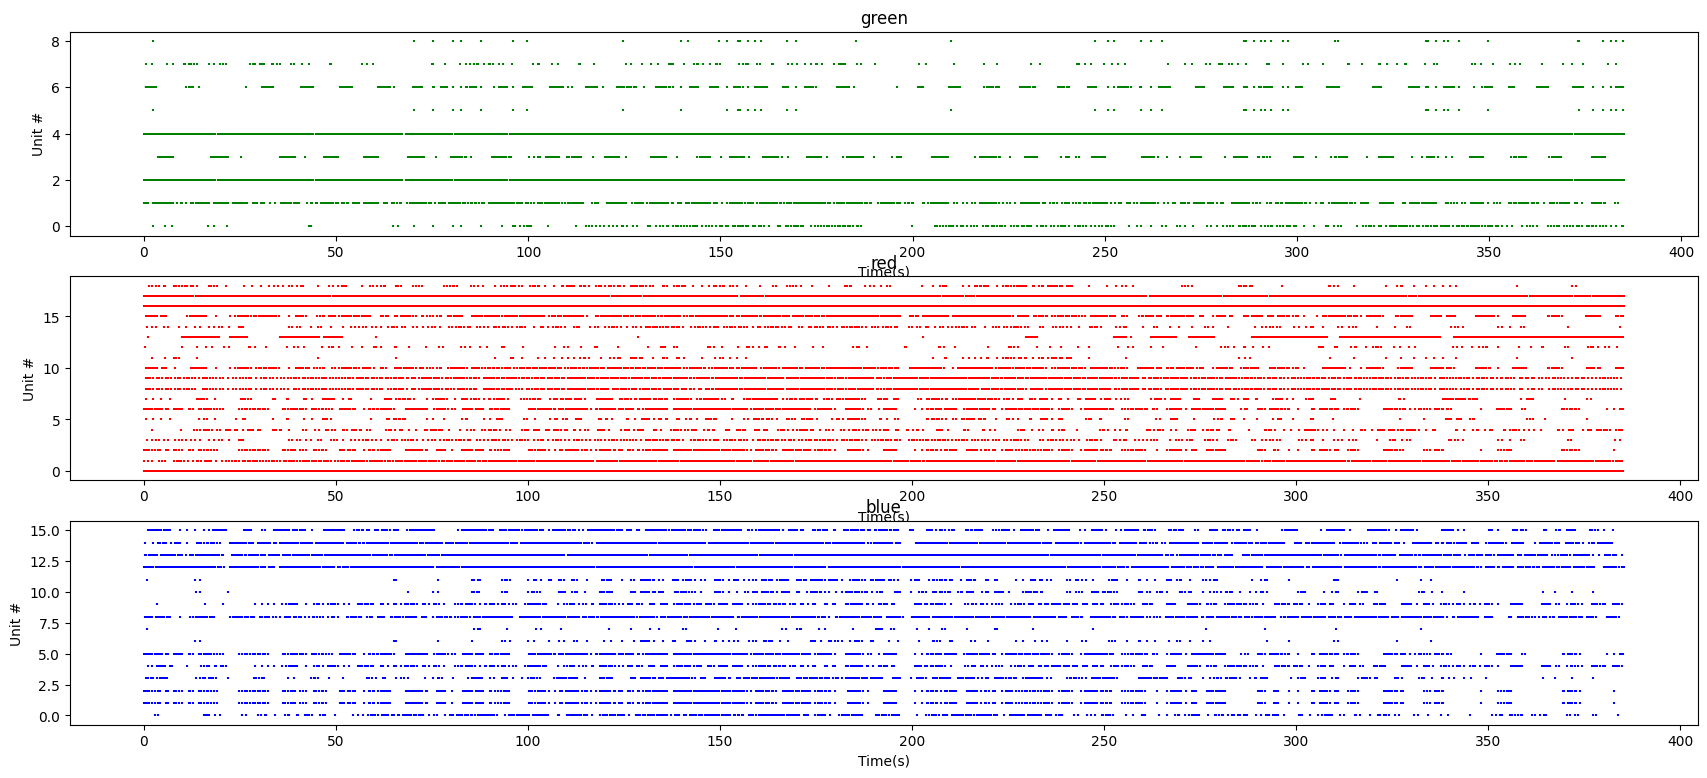

In [93]:
fig, axs = plt.subplots(3, 1, figsize=(21, 9))  # 3 rows, 1 column

plot_raster_color(sd_green, axs[0], 'green')
plot_raster_color(sd_red, axs[1], 'red')
plot_raster_color(sd_blue, axs[2], 'blue')
plt.tight_layout
plt.show()

/tmp/ipykernel_1853342/3839061738.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


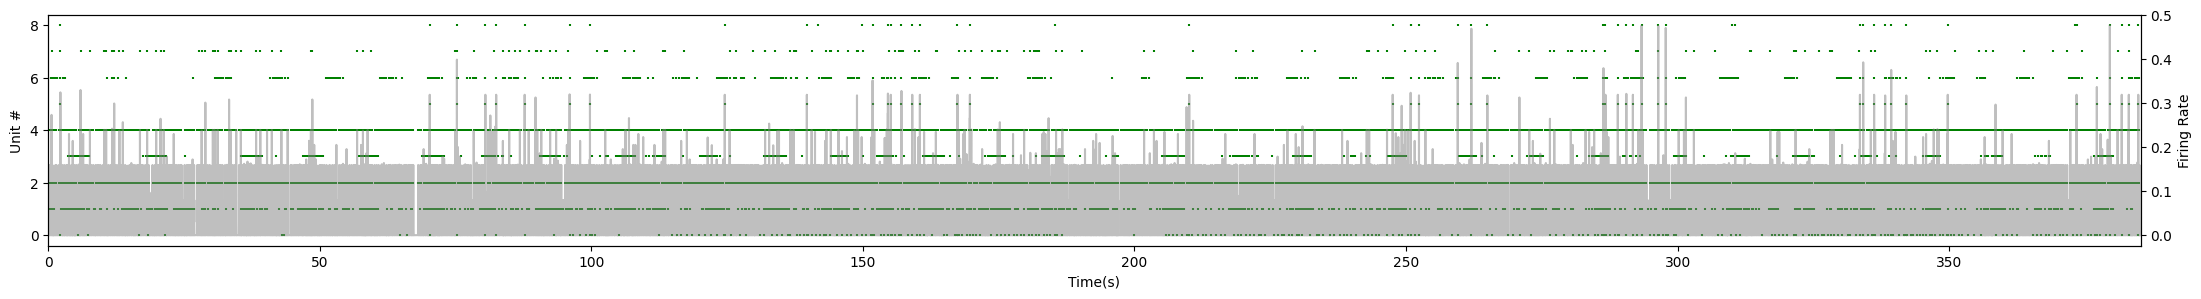

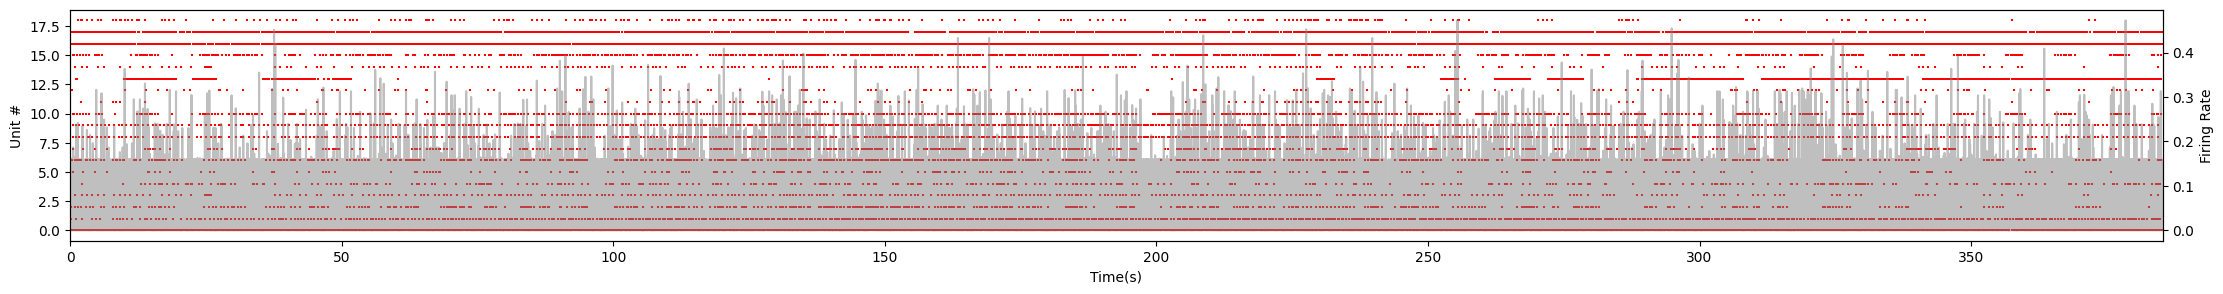

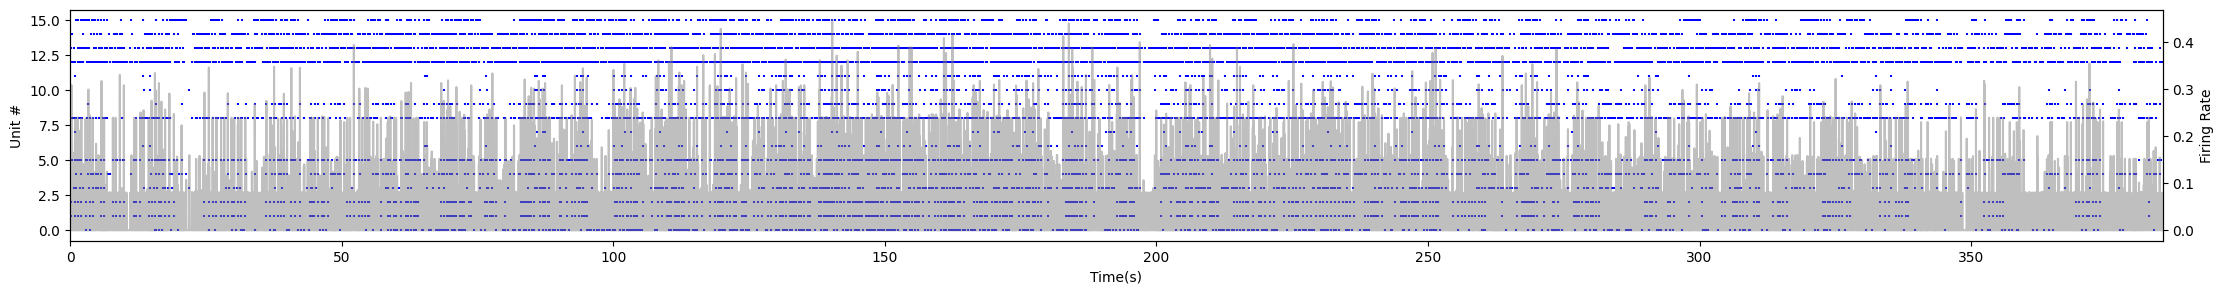

<Figure size 640x480 with 0 Axes>

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

def raster_analysis(sd, seconds=None, color='grey'):
    if seconds is None:
        seconds = sd.length / 1000
        
    idces, times = sd.idces_times()

    pop_rate = sd.binned(bin_size=1)
    sigma = 5
    pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float), sigma=sigma)
    t = np.linspace(0, sd.length, pop_rate.shape[0]) / 1000

    fig, ax = plt.subplots(figsize=(27, 3))
    ax.scatter(times / 1000, idces, marker='|', s=1, c=color)
    ax2 = ax.twinx()
    ax2.plot(t, pop_rate_smooth, c='grey', alpha=0.5)
    ax.set_xlim(0, seconds)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax2.set_ylabel('Firing Rate')
    plt.show()

# Create a figure with three subplots stacked vertically
fig, axs = plt.subplots(3, 1, figsize=(27, 9))  # 3 rows, 1 column

# Close the initial empty plots
plt.close(fig)

# Call the raster_analysis function for each subplot
raster_analysis(sd_green, color='green')
raster_analysis(sd_red, color='red')
raster_analysis(sd_blue, color='blue')

plt.tight_layout()
plt.show()

/tmp/ipykernel_1853342/832630796.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


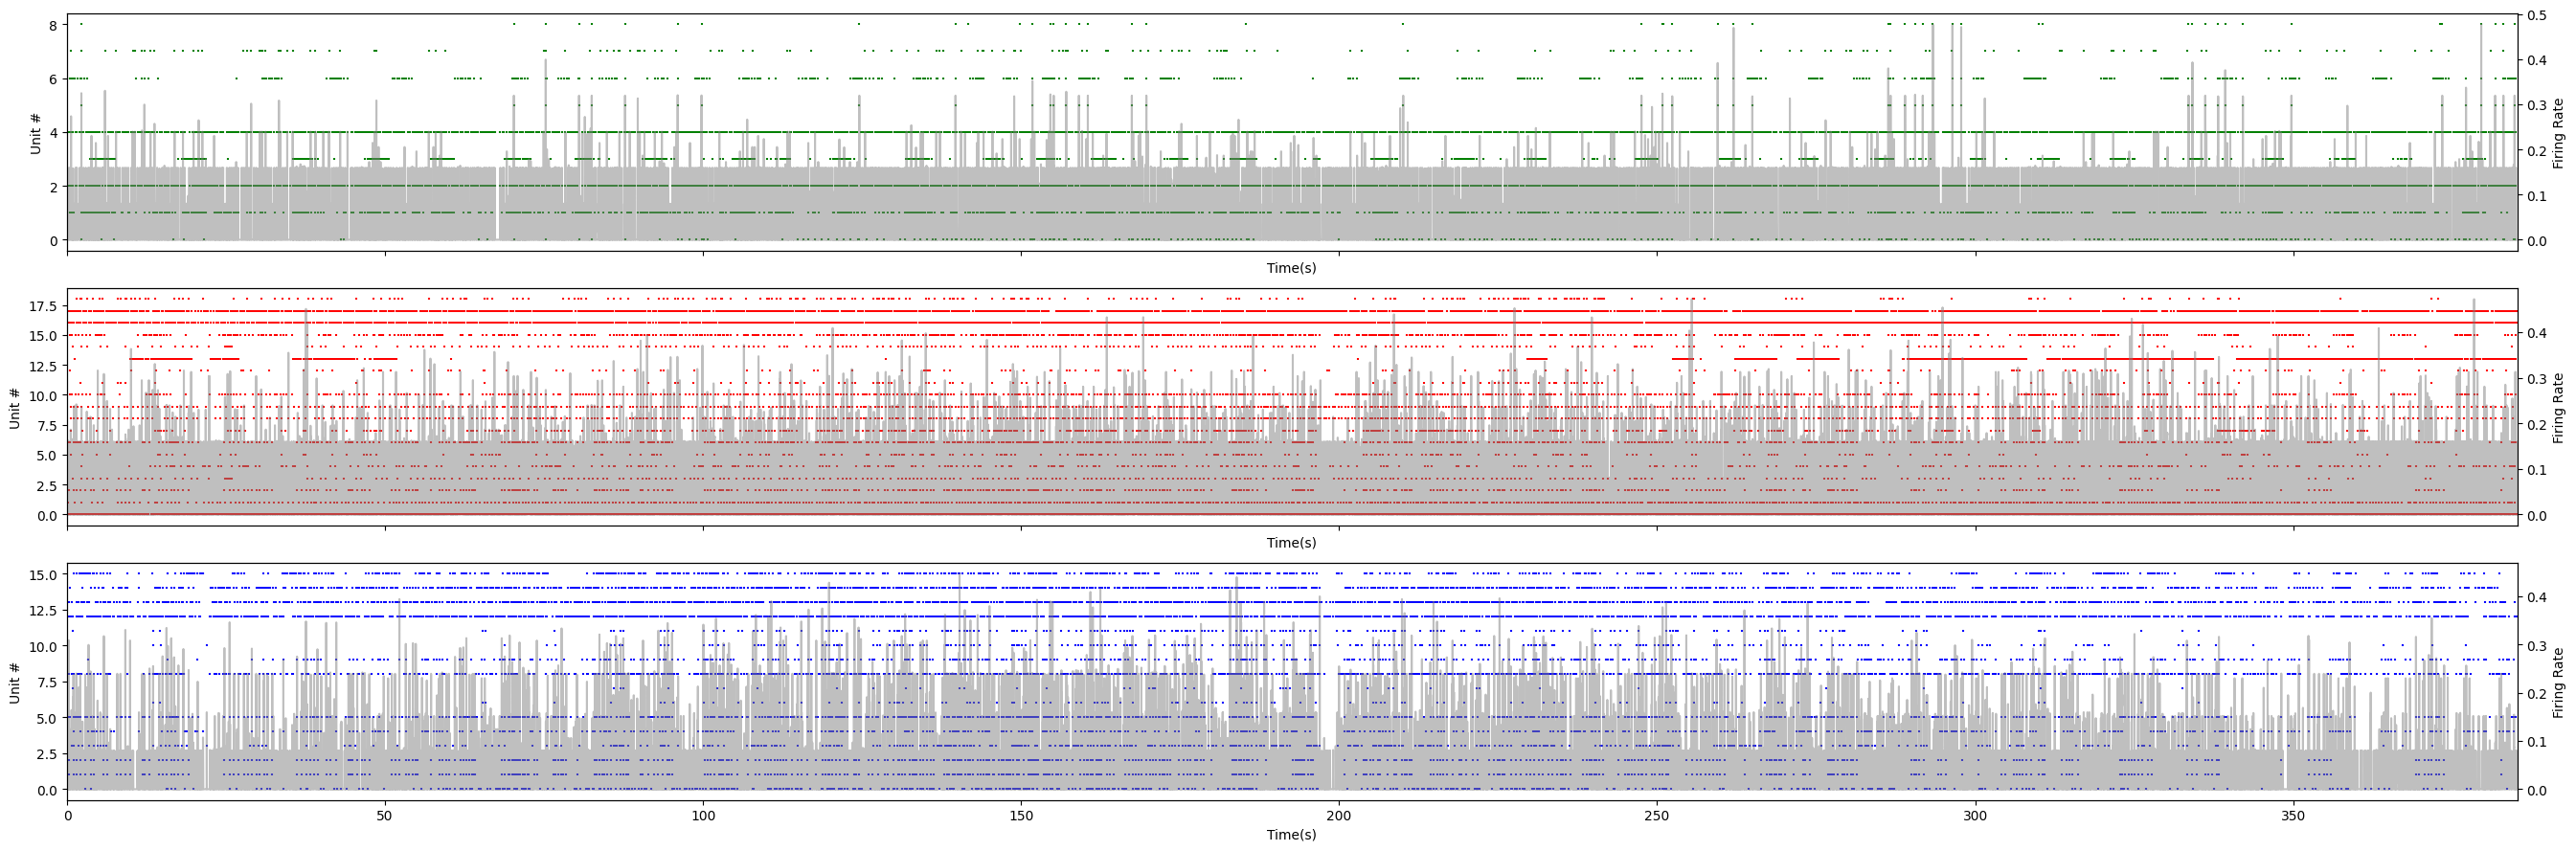

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

def raster_analysis(sd, ax, seconds=None, color='grey'):
    if seconds is None:
        seconds = sd.length / 1000
        
    idces, times = sd.idces_times()

    pop_rate = sd.binned(bin_size=1)
    sigma = 5
    pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float), sigma=sigma)
    t = np.linspace(0, sd.length, pop_rate.shape[0]) / 1000

    ax.scatter(times / 1000, idces, marker='|', s=1, c=color)
    ax2 = ax.twinx()
    ax2.plot(t, pop_rate_smooth, c='grey', alpha=0.5)
    ax.set_xlim(0, seconds)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax2.set_ylabel('Firing Rate')

# Create a figure with three subplots stacked vertically and share the x-axis
fig, axs = plt.subplots(3, 1, figsize=(27, 9), sharex=True)  # 3 rows, 1 column

# Call the raster_analysis function for each subplot
raster_analysis(sd_green, axs[0], color='green')
raster_analysis(sd_red, axs[1], color='red')
raster_analysis(sd_blue, axs[2], color='blue')

plt.tight_layout()
plt.show()

In [121]:
def raster_analysis(sd, seconds=sd.length/1000, color='grey'):
    # Zoomed Raster and pop rate
    # Get coordinates for raster
    idces, times = sd.idces_times()

    # Get population rate for everything
    pop_rate = sd.binned(bin_size=1)# in ms
    print(pop_rate)
    # Lets smooth this to make it neater
    sigma = 5
    pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float),sigma=sigma) 
    t = np.linspace(0,sd.length,pop_rate.shape[0])/1000

    fig, ax = plt.subplots()

    ax.scatter(times/1000,idces,marker='|',s=1,c=color)
    ax2 = ax.twinx()
    ax2.plot(t,pop_rate_smooth,c='grey',alpha=0.5)

    ax.set_xlim(0,seconds)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax2.set_ylabel('Firing Rate')
    plt.show()

[0 0 0 ... 0 0 0]


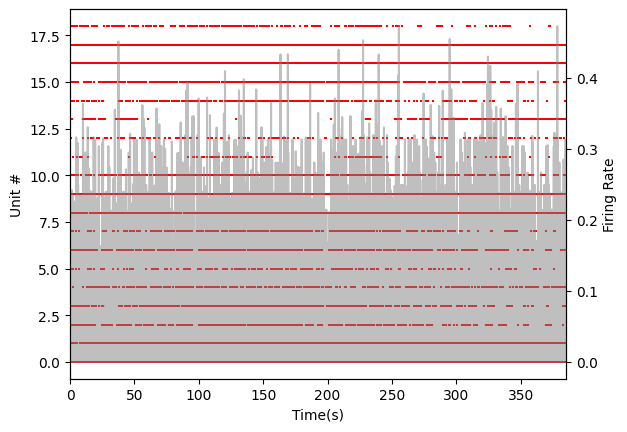

In [122]:
raster_analysis(sd_red,color='red')

In [111]:
len(sd_red.binned(1))

385239

In [73]:
def plot_raster(sd, ax):
    idces, times = sd.idces_times()
    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax.set_title("Raster Plot")

In [ ]:
# Set up figure
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

plt.scatter(neuron_x, neuron_y, alpha=0.15, c='grey')

# Plot each individual arrow
for i in range(len(lates_directed)):
    
    # Get starting and ending arrow based on direction
    is_pos = np.median(lates_directed[i]) > 0
    if is_pos:
        start_i = pairs_directed[i][0]
        end_i = pairs_directed[i][1]
    else:
        start_i = pairs_directed[i][1]
        end_i = pairs_directed[i][0]

        
    arrow_color="black"
    if (neuron_y[start_i] < 500 or neuron_y[end_i] < 500):
        arrow_color="green"
        
    if neuron_x[start_i] < neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
        arrow_color="red"
    
    if neuron_x[start_i] > neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
        arrow_color = "blue"
        
        #         continue
        
    #if neuron_y[start_i] < neuron_y[end_i]:
    #    continue
   
    #arrow_color="black"
    # Add arrow
    arrow = FancyArrow(
        neuron_x[end_i], neuron_y[end_i],
        neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i],
        length_includes_head=True, head_width=25,
        linewidth=1, color=arrow_color, alpha=0.7, edgecolor=arrow_color, facecolor=arrow_color)
    plt.gca().add_patch(arrow)
    

plt.xlabel('um')
plt.ylabel('um')
plt.title("Directionality plot")  # Adding the title
plt.show()

## Latencies Directionality

In [9]:
direction_threshold = .65

In [10]:
lates_directed = []
pairs_directed = []

In [15]:
for i in range(len(lates_short)):
    lates_i = np.array(lates_short[i])
    print(len(lates_i))
    if len(lates_i) == 0:
        continue
    percent_neg = sum( lates_i<0 )/len(lates_i)
    percent_pos = sum( lates_i>0 )/len(lates_i)
    
    if percent_neg > direction_threshold or percent_pos > direction_threshold:
        lates_directed.append( lates_i )
        pairs_directed.append( lates_pairs[i] )

196
348
170
136
126
473
1592
119
734
453
453
187
217
58
453
453
236
268
166
246
1599
89
526
73
1441
432
139
188
214
58
73
456
456
1434
214
48
48
47
607
107
43
141
1343
96
216
141
606
306
515
433
134
47
1343
96
224
45
97
118
119
88
246
107
43
735
525
46
46
45
283
234
48
268
462
46
194
128
46
520
1275
346
125
1291
234
119
200
97
97
133
133
45
45
46
196
143
135
98


In [12]:
len( pairs_directed )

54

## Plot Latencies in  Layout view

get neuron x and y values

In [12]:
neuron_x = []
neuron_y = []
for neuron in sd.neuron_data[0].values():
    neuron_x.append(neuron['position'][0])
    neuron_y.append(neuron['position'][1])

/tmp/ipykernel_1851499/3713121702.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


### plot attempt 1

/tmp/ipykernel_1851499/1754740420.py:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow( neuron_x[end_i], neuron_y[end_i], neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i], length_includes_head=True, head_width=25,


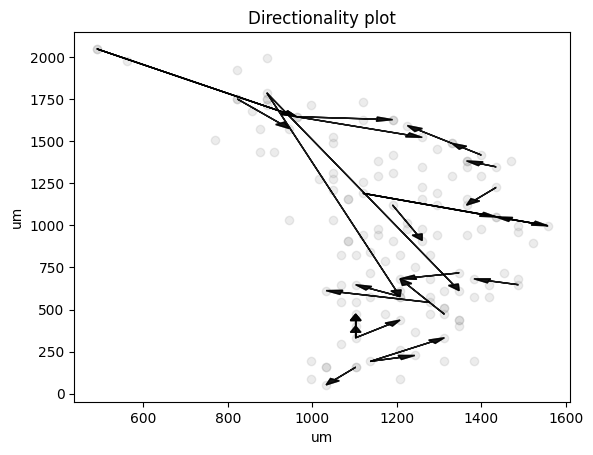

In [13]:
# Set up figure
plt.figsize= (1,1)

plt.scatter(neuron_x, neuron_y, alpha = 0.15, c='grey')

# Plot each individual arrow
for i in range(len(lates_directed)):
    
    # Get starting and ending arrow based on direction
    is_pos = np.median(lates_directed[i])>0
    if is_pos:
        start_i =  pairs_directed[i][0]
        end_i = pairs_directed[i][1]
    else:
        start_i =  pairs_directed[i][1]
        end_i = pairs_directed[i][0] 
    
    # plot dummy points, delete this soon  
#      plt.scatter( neuron_x[start_i], neuron_y[start_i], alpha=.1, c='b', s = 100)
#    plt.scatter( neuron_x[end_i], neuron_y[end_i], alpha=.1, c='r', s = 100 )
    
#     plt.scatter(neuron_x, neuron_y, alpha=.1)
    
    # add arrow
    arrow = FancyArrow( neuron_x[end_i], neuron_y[end_i], neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i], length_includes_head=True, head_width=25,
                                       linewidth=1, color='black', alpha=0.7, edgecolor='black', facecolor='black')
    plt.gca().add_patch(arrow)

plt.xlabel('um')
plt.ylabel('um')
plt.title("Directionality plot")  # Adding the title
plt.show()

/tmp/ipykernel_1851499/2565261294.py:36: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow(


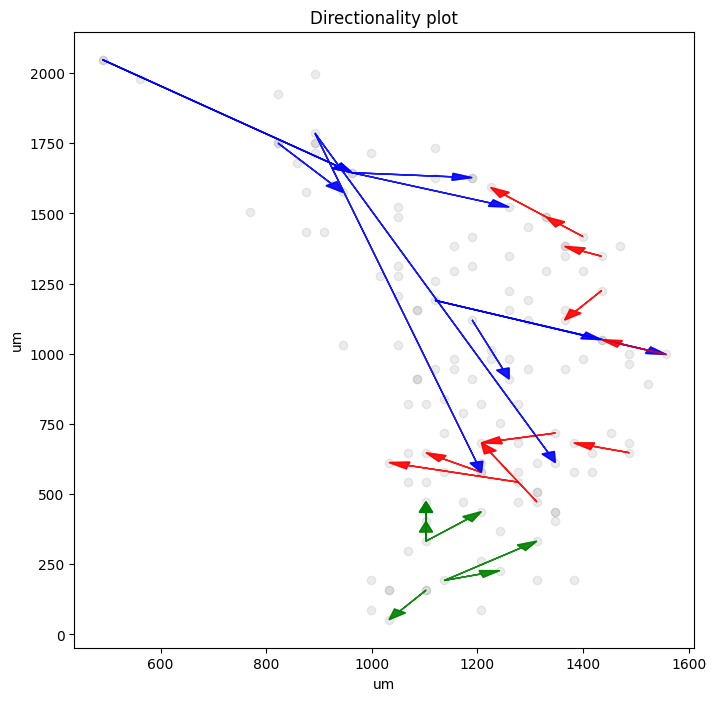

In [14]:
# Set up figure
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

plt.scatter(neuron_x, neuron_y, alpha=0.15, c='grey')

# Plot each individual arrow
for i in range(len(lates_directed)):
    
    # Get starting and ending arrow based on direction
    is_pos = np.median(lates_directed[i]) > 0
    if is_pos:
        start_i = pairs_directed[i][0]
        end_i = pairs_directed[i][1]
    else:
        start_i = pairs_directed[i][1]
        end_i = pairs_directed[i][0]

        
    arrow_color="black"
    if (neuron_y[start_i] < 500 or neuron_y[end_i] < 500):
        arrow_color="green"
        
    if neuron_x[start_i] < neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
        arrow_color="red"
    
    if neuron_x[start_i] > neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
        arrow_color = "blue"
        
        #         continue
        
    #if neuron_y[start_i] < neuron_y[end_i]:
    #    continue
   
    #arrow_color="black"
    # Add arrow
    arrow = FancyArrow(
        neuron_x[end_i], neuron_y[end_i],
        neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i],
        length_includes_head=True, head_width=25,
        linewidth=1, color=arrow_color, alpha=0.7, edgecolor=arrow_color, facecolor=arrow_color)
    plt.gca().add_patch(arrow)
    

plt.xlabel('um')
plt.ylabel('um')
plt.title("Directionality plot")  # Adding the title
plt.show()

In [ ]:
neuron_x = []
neuron_y = []
for neuron in sd.neuron_data[0].values():
    neuron_x.append(neuron['position'][0])
    neuron_y.append(neuron['position'][1])

In [ ]:
blue_lates=[]
red_lates =[]
green_lates=[]


# Plot each individual arrow
for i in range(len(lates_directed)):
    
    # Get starting and ending arrow based on direction
    is_pos = np.median(lates_directed[i]) > 0
    if is_pos:
        start_i = pairs_directed[i][0]
        end_i = pairs_directed[i][1]
    else:
        start_i = pairs_directed[i][1]
        end_i = pairs_directed[i][0]

        
    #arrow_color="black"
    if (neuron_y[start_i] < 500 or neuron_y[end_i] < 500):
        green_lates.append( sd.latencies_to_index(end_i)[start_i]  )
        #arrow_color="green"
        #print(start_i)
        
    if neuron_x[start_i] < neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
        #arrow_color="red"
        red_lates.append( sd.latencies_to_index(end_i)[start_i]  )
    
    if neuron_x[start_i] > neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
        #arrow_color = "blue"
        blue_lates.append( sd.latencies_to_index(end_i)[start_i]  )
        

### print euclidean distance

In [39]:
pairs = []

# Plot each individual arrow
for i in range(len(lates_directed)):
    
    # Get starting and ending arrow based on direction
    is_pos = np.median(lates_directed[i])>0
    if is_pos:
        start_i =  pairs_directed[i][0]
        end_i = pairs_directed[i][1]
    else:
        start_i =  pairs_directed[i][1]
        end_i = pairs_directed[i][0] 
    
    pair_distance = np.sqrt( (neuron_x[end_i] - neuron_x[start_i] )**2 + (neuron_y[end_i] - neuron_y[start_i] )**2 )
    pairs.append(pair_distance)
    print(pair_distance)
    

221.35943621178654
234.7871376374779
144.30869689661813
344.7100230628637
477.9775099311682
126.19429464123962
344.7100230628637
133.2760293526184
213.6147232753398
78.26237921249263
1247.9107540204948
126.19429464123962
126.19429464123962
477.9775099311682
133.2760293526184
126.19429464123962
70.0
140.0
98.99494936611666
620.695174783887
620.695174783887
126.19429464123962
110.67971810589327
224.1093483101497
126.19429464123962
98.99494936611666
228.1720841820927
148.49242404917499
1247.9107540204948
1257.6888526181665
110.67971810589327
213.6147232753398
110.67971810589327
234.7871376374779
620.695174783887
620.695174783887
144.30869689661813
70.0
70.0
228.1720841820927
321.7335854398791
78.26237921249263
148.49242404917499
148.49242404917499
254.80384612481814
254.80384612481814
321.7335854398791
224.1093483101497
221.35943621178654
140.0
70.0
148.49242404917499
1257.6888526181665
110.67971810589327


In [41]:
len(pairs)

54

In [43]:
len(np.unique(pairs))

21

### plot

/tmp/ipykernel_1135338/2677915455.py:6: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow( neuron_x[end_i], neuron_y[end_i], neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i], length_includes_head=True, head_width=3,


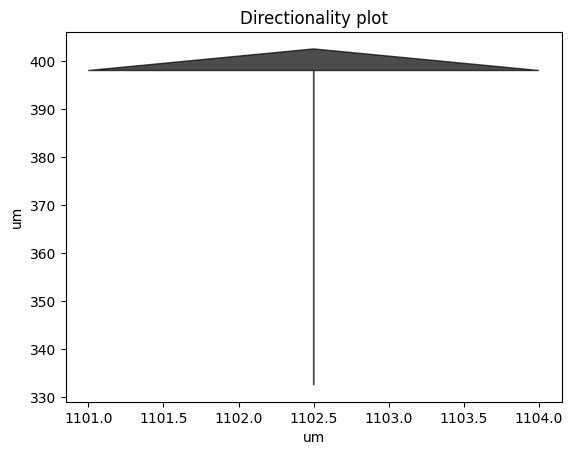

In [54]:
#fig, ax = plt.subplots(figsize=(8, 6))
plt.figsize= (8,6)
plt.scatter( neuron_x[start_i], neuron_y[start_i], alpha=0 )
#plt.xlim(500,1600)
#plt.ylim(0,2200)
arrow = FancyArrow( neuron_x[end_i], neuron_y[end_i], neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i], length_includes_head=True, head_width=3,
                                   linewidth=1, color='black', alpha=0.7, edgecolor='black', facecolor='black')
plt.gca().add_patch(arrow)


plt.xlabel('um')
plt.ylabel('um')
plt.title("Directionality plot")  # Adding the title
plt.show()

/tmp/ipykernel_1135338/3483360784.py:3: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow(neuron_x[end_i], neuron_y[end_i], neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i],


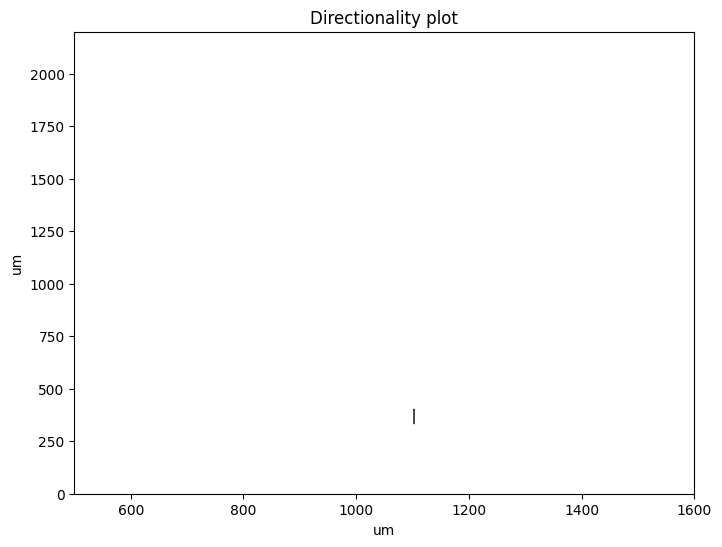

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(neuron_x[start_i], neuron_y[start_i], alpha=0)
arrow = FancyArrow(neuron_x[end_i], neuron_y[end_i], neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i],
                   length_includes_head=True, head_width=3, linewidth=1, color='black', alpha=0.7, edgecolor='black', facecolor='black')
ax.add_patch(arrow)
plt.xlim(500, 1600)
plt.ylim(0, 2200)
ax.set_xlabel('um')
ax.set_ylabel('um')
ax.set_title("Directionality plot")  # Adding the title
plt.show()

### <font color="brown">reference code

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(neuron_x, neuron_y, s=neuron_amp, c=upd_node_info)
threshold = thresh
sttc = inp_sd.spike_time_tilings()
for i in range(sttc.shape[0]):
    for j in range(sttc.shape[1]):
        if i <= j:
            continue
        if sttc[i, j] < threshold:
            continue
#             if i in [7, 10, 16, 43, 48, 66, 67]:
#                 continue
#             if j in [7, 10, 16, 43, 48, 66, 67]:
            continue
        ix, iy = inp_sd.neuron_data[0][i]['position']
        jx, jy = inp_sd.neuron_data[0][j]['position']
        linewidth = 1.5 + 2 * (sttc[i, j] - threshold)
        opacity = 0.2 + 0.8 * (sttc[i, j] - threshold)
        if upd_node_info[i] == 'blue' and upd_node_info[j] == 'red':
            linewidth = 2.0  # Set a thicker linewidth
            arrow = FancyArrow(jx, jy, ix - jx, iy - jy, length_includes_head=True, head_width=35,
                               linewidth=linewidth, color='black', alpha=0.7, edgecolor='black', facecolor='black')
            plt.gca().add_patch(arrow)
        else:
            ax.plot([ix, jx], [iy, jy], linewidth=linewidth, color='grey', alpha=opacity)
ax.set_xlabel('um')
ax.set_ylabel('um')
ax.set_title("Directionality plot")  # Adding the title

In [ ]:
arrow = FancyArrow(jx, jy, ix - jx, iy - jy, length_includes_head=True, head_width=2,
                                   linewidth=1, color='black', alpha=0.7, edgecolor='black', facecolor='black')
                plt.gca().add_patch(arrow)

# <font color="gray">reference code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_latency_histograms_for_random_pairs(sd, threshold=0.3, num_random_pairs=30):
    neuron_pairs = find_sttc_above_threshold(sd, threshold)

    # Get 'num_random_pairs' random indices to choose random neuron pairs
    random_indices = np.random.choice(neuron_pairs.shape[0], num_random_pairs, replace=False)
    random_neuron_pairs = neuron_pairs[random_indices]
    
    fig, axs = plt.subplots(8, 8, figsize=(30, 30))
    axs = axs.ravel()

    # Collect latency data from all neuron pairs
    all_lates = []

    for i, neuron_pair in enumerate(random_neuron_pairs):
        neuron1, neuron2 = neuron_pair
        lates_n1 = sd.latencies_to_index(neuron1)
        lates_raw = lates_n1[neuron2]
        lates = list(filter(lambda x: x < 10 and x > -10, lates_raw))

        all_lates.extend(lates)  # Collect all latencies for setting common axis limits

        mean_latency = np.mean(lates)
        std_latency = np.std(lates)

        axs[i].hist(lates, bins=10, alpha=0.7, label='Latency')
        axs[i].axvline(mean_latency, color='red', linestyle='dashed', linewidth=2, label='Mean')
        axs[i].axvline(mean_latency - std_latency, color='green', linestyle='dashed', linewidth=2, label='Std -')
        axs[i].axvline(mean_latency + std_latency, color='green', linestyle='dashed', linewidth=2, label='Std +')

        axs[i].set_xlabel("Latency (ms)")
        axs[i].set_ylabel("Number of spike pairs")
        axs[i].set_title(f"Latency Histogram - Neuron Pair {neuron1} and {neuron2}")

    # Calculate common axis limits from all latencies
    common_x_limit = (-10, 10)  # You can adjust the range if needed
    common_y_limit = (0, len(all_lates)//10)  # Dividing by 10 just to set a reasonable range for the y-axis

    # Set common axis limits for all subplots
    for ax in axs:
        ax.set_xlim(common_x_limit)
        ax.set_ylim(common_y_limit)

    # Hide unused subplots
    for i in range(num_random_pairs, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.savefig('LatencyDistributions.png')
    plt.show()

# Call the function with your SpikeData object, the desired STTC threshold, and the number of random pairs to plot
plot_latency_histograms_for_random_pairs(sd, threshold=0.48, num_random_pairs=64)